In [130]:
import dicom
import inspect
import pylab
import numpy as np
from glob import glob
import os

import matplotlib
import matplotlib.pyplot as plt

from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator

from ml_utils import *
import math
from sys import stdout

In [218]:
_benigns = np.load('benign_cropped.npy')
_maligns = np.load('malig_cropped.npy')
#nroi = np.load('nroi.npy')
np.random.shuffle(_benigns)
np.random.shuffle(_maligns)

In [219]:
benigns = preprocess(np.array(list(map(getFromSlice('roi'), flatten(benigns)))))
maligns = preprocess(np.array(list(map(getFromSlice('roi'), flatten(maligs)))))
#nroi = preprocess(np.array(list(map(getFromSlice('nroi'), flatten(nroi)))))

IndexError: only integers, slices (`:`), ellipsis (`...`), numpy.newaxis (`None`) and integer or boolean arrays are valid indices

In [9]:
models = glob('model-babystep3*.h5')

In [20]:
model = load_model('model-babystep3-fcn-rmoved-tertiary-classification-improved.h5')

In [52]:
preds = {'benign': [], 'malig': [], 'nroi': []}
for model_name in models:
    model = load_model(model_name)
    print('model : %s' % model_name)
    pred = model.predict(benigns)
    if (pred.shape[1] == 4):
        pred = np.hstack((pred[:,:1], pred[:, 2:]))
    pred = np.argmax(pred, axis =1)
    preds['benign'].append(pred)
    correct = (pred == 1).sum()
    print ('benign : %d/%d : %.3f' % (correct, pred.shape[0], correct / pred.shape[0]))
    pred = model.predict(maligs)
    if (pred.shape[1] == 4):
        pred = np.hstack((pred[:,:1], pred[:, 2:]))
    pred = np.argmax(pred, axis =1)
    preds['malig'].append(pred)
    correct = (pred == 2).sum()
    print ('malign. : %d/%d : %.3f' % (correct, pred.shape[0], correct / pred.shape[0]))
    ## samples are too 
    pred = model.predict(nroi)
    if (pred.shape[1] == 4):
        pred = np.hstack((pred[:,:1], pred[:, 2:]))
    pred = np.argmax(pred, axis =1)
    preds['nroi'].append(pred)
    correct = (pred == 0).sum()
    print ('nroi : %d/%d : %.3f' % (correct, pred.shape[0], correct / pred.shape[0]))

model : model-babystep3-fcn-rmoved-tertiary-classification-improved.h5
benign : 209/219 : 0.954
malign. : 824/1117 : 0.738
nroi : 54937/55154 : 0.996
model : model-babystep3-default_softmax_classification.h5
benign : 194/219 : 0.886
malign. : 1098/1117 : 0.983
nroi : 54946/55154 : 0.996
model : model-babystep3-fcn-rmoved-tertiary-classification-improved2.h5
benign : 207/219 : 0.945
malign. : 1038/1117 : 0.929
nroi : 54859/55154 : 0.995
model : model-babystep3-fcn-rmoved-tertiary-classification.h5
benign : 188/219 : 0.858
malign. : 868/1117 : 0.777
nroi : 49662/55154 : 0.900
model : model-babystep3-control-triple-binary-classification.h5
benign : 204/219 : 0.932
malign. : 1082/1117 : 0.969
nroi : 55095/55154 : 0.999
model : model-babystep3-composite-tertiary-classification.h5
benign : 208/219 : 0.950
malign. : 1100/1117 : 0.985
nroi : 55016/55154 : 0.997


In [53]:
ps = np.vstack(preds['nroi'])

In [54]:
from collections import Counter
p = [Counter(ps.T[i]).most_common(1)[0][0] for i in range(ps.T.shape[0])]   

In [56]:
pp = np.array(p)
print( (pp == 0).sum(), pp.shape[0], (pp == 0).sum() / pp.shape[0])

55068 55154 0.998440729594


In [3]:
model1 = load_model('../saved_models/model-babystep3-control-triple-binary-classification.h5')

model2 = load_model('../saved_models/model-babystep3-fcn-rmoved-tertiary-classification-improved2.h5')

model3 = load_model('../saved_models/model-babystep3-composite-tertiary-classification.h5')
model4 = load_model('../saved_models/model-babystep3-default_softmax_classification.h5')

In [189]:
model = model1

In [ ]:
model = model3
print('model : %s' % 'default-2d-classification-model')
pred = model.predict(benigns)
if (pred.shape[1] == 4):
    pred = pred[:,2:]
else:
    pred = pred[:,1:]

pred = np.argmax(pred, axis=1)
#preds['benign'].append(pred)
correct = (pred == 0).sum()
print ('benign : %d/%d : %.3f' % (correct, pred.shape[0], correct / pred.shape[0]))
pred = model.predict(maligns)
if (pred.shape[1] == 4):
    pred = pred[:,2:]
else:
    pred = pred[:,1:]
pred = np.argmax(pred, axis =1)
#preds['malig'].append(pred)
correct = (pred == 1).sum()
print ('malign. : %d/%d : %.3f' % (correct, pred.shape[0], correct / pred.shape[0]))

model : default-2d-classification-model
benign : 208/219 : 0.950
malign. : 1104/1117 : 0.988


default setting 에서 malignant 의 accuracy 는 1103 / 1103 + 15. 물론 현재 데이터셋에서 malign 수가 많음에 따른 현상을 고려해야함

In [61]:
def predict(samples):
    pred = model.predict(samples)
    if (pred.shape[1] == 4):
        pred = pred[:,2:]
    else:
        pred = pred[:,1:]
    return pred

def predict_patient(samples):
    pred = model.predict(samples)
    if (pred.shape[1] == 4):
        pred = pred[:,2:]
    else:
        pred = pred[:,1:]
    return pred.mean(axis=0)

In [62]:
def prec_recall(bp, mp, dev):
    tp = (np.argmax(mp + [0, dev], axis = 1) == 1).sum()
    fp = (np.argmax(bp + [0, dev], axis = 1) == 1).sum()
    tn = (np.argmax(bp + [0, dev], axis = 1) == 0).sum()
    fn = (np.argmax(mp + [0, dev], axis = 1) == 0).sum()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    return precision, recall

In [220]:
getROI = lambda slice: slice['roi']
benigns = [preprocess(np.array([getROI(slice) for slice in benign])) for benign in _benigns[:31]]
maligns = [preprocess(np.array([getROI(slice) for slice in malign])) for malign in _maligns[:116]]
#nroi = preprocess(np.array(list(map(getFromSlice('nroi'), flatten(nroi)))))

In [221]:
bp = np.array(list(map(predict_patient, benigns)))
mp = np.array(list(map(predict_patient, maligns)))

In [222]:
print(bp.shape, mp.shape)

print((bp[:,0] > bp[:,1]).sum())
print((mp[:,0] < mp[:,1]).sum())

(31, 2) (116, 2)
29
115


In [223]:
plots = np.array([list(prec_recall(bp, mp, dev * 0.1 - 1)) for dev in range(11)])

/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in long_scalars


In [224]:
plots

array([[        nan,  0.        ],
       [ 1.        ,  0.89655172],
       [ 1.        ,  0.93965517],
       [ 1.        ,  0.95689655],
       [ 1.        ,  0.97413793],
       [ 1.        ,  0.97413793],
       [ 0.99130435,  0.98275862],
       [ 0.99130435,  0.98275862],
       [ 0.99130435,  0.98275862],
       [ 0.99130435,  0.98275862],
       [ 0.98290598,  0.99137931]])

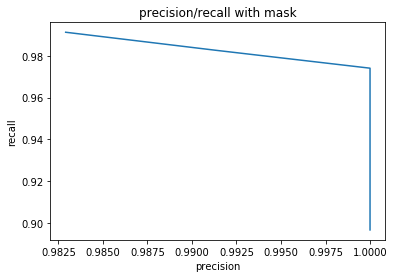

In [226]:
plt.plot(plots[:,0], plots[:,1])
plt.xlabel('precision')
plt.ylabel('recall')
plt.title('precision/recall with mask')
plt.show()


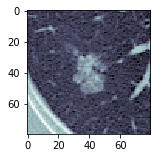

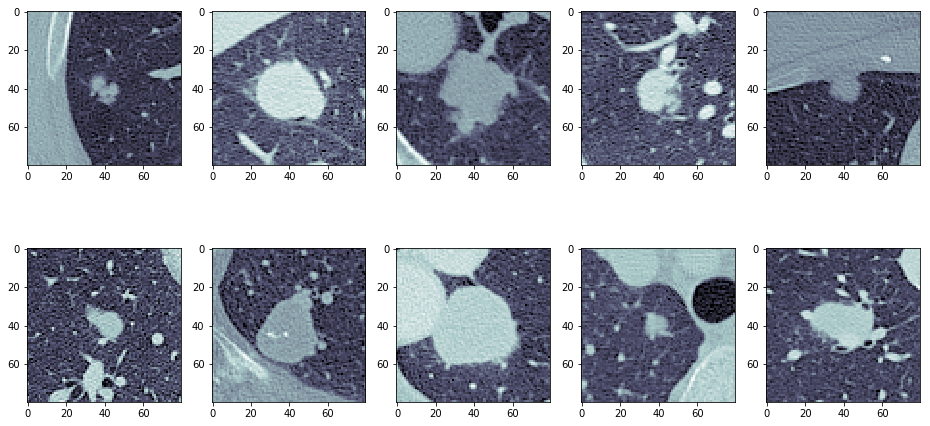

In [12]:
bh = bp[:,0] - bp[:,1]

plt.figure(figsize=(16,8))
for i, b in enumerate(benigns[np.argsort(bh)[:10]]):
    plt.subplot(2,5,i+1)
    plt.imshow(b.reshape((80,80)), plt.cm.bone)
plt.show()

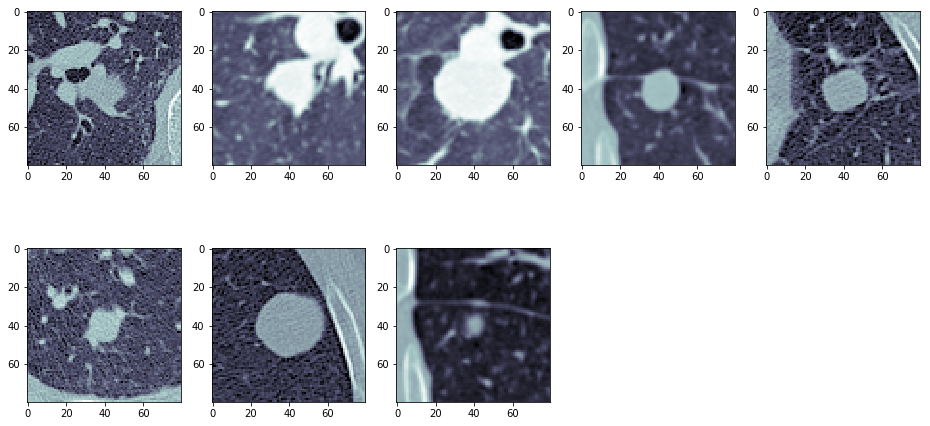

In [95]:
bh = bp[:,0] - bp[:,1]

plt.figure(figsize=(16,8))
for i, b in enumerate(benigns[np.argsort(bh)[[-1,-2,-3,-13,-14,-15,-16,-17]]]):
    plt.subplot(2,5,i+1)
    plt.imshow(b.reshape((80,80)), plt.cm.bone)
plt.show()

-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0
-1.0


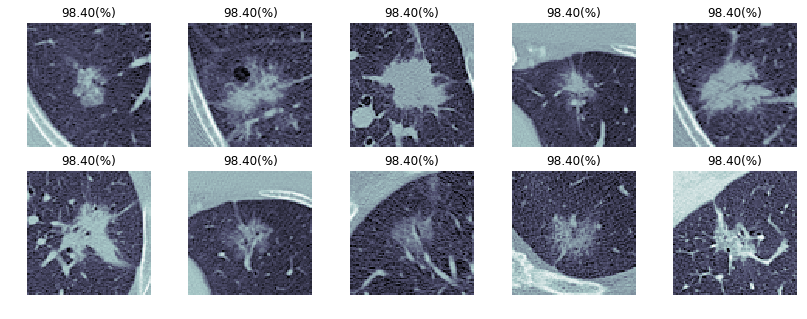

In [37]:
mh = mp[:,0] - mp[:,1]

plt.figure(figsize=(14,5))
for i, m in enumerate(maligns[np.argsort(mh)[:10]]):
    plt.subplot(2,5,i+1)
    plt.imshow(m.reshape((80,80)), plt.cm.bone)
    sub = mh[np.argsort(mh)][:10][i]
    print(sub)
    plt.title('%.2f(%%)' % (malig_prob(sub) * 100))
    plt.axis('off')
plt.show()

0.772411
0.830977
0.927179
0.976445
0.976528
0.980574
0.998215
0.999474
0.999806
0.999998


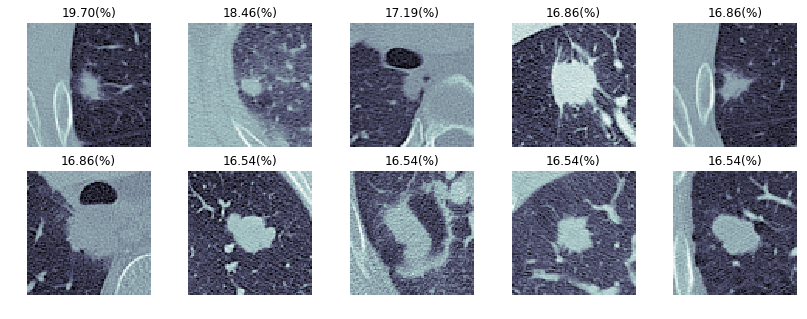

In [36]:
mh = mp[:,0] - mp[:,1]

plt.figure(figsize=(14,5))
for i, m in enumerate(maligns[np.argsort(mh)[-10:]]):
    plt.subplot(2,5,i+1)
    plt.imshow(m.reshape((80,80)), plt.cm.bone)
    sub = mh[np.argsort(mh)][-10:][i]
    print(sub)
    plt.title('%.2f(%%)' % (malig_prob(sub) * 100))
    plt.axis('off')
plt.show()

In [35]:
def malig_prob(s):
    if s == 
    tp = (mh[(mh <= s + 1.5)] >= s - 1.5).sum()
    fp = (bh[(bh <= s + 1.5)] >= s - 1.5).sum()
    return tp / (fp + tp)

In [133]:
bp

array([[  9.61369872e-01,   3.63104953e-03],
       [  1.00000000e+00,   6.36736663e-09],
       [  1.00000000e+00,   4.19181237e-13],
       [  5.53954899e-01,   2.97692239e-01],
       [  1.00000000e+00,   3.11691312e-18],
       [  4.34030662e-05,   8.94819241e-05],
       [  1.00000000e+00,   8.49929502e-13],
       [  1.00000000e+00,   4.79228428e-11],
       [  9.99999404e-01,   1.23931727e-07],
       [  9.99955893e-01,   1.24676681e-05],
       [  1.00000000e+00,   1.01162341e-08],
       [  1.00000000e+00,   3.75795950e-10],
       [  1.00000000e+00,   5.16710264e-13],
       [  1.00000000e+00,   4.90196537e-18],
       [  1.00000000e+00,   5.92877830e-25],
       [  1.00000000e+00,   1.43275582e-12],
       [  1.00000000e+00,   1.77826451e-11],
       [  1.00000000e+00,   1.62103433e-08],
       [  9.99999762e-01,   1.12616213e-07],
       [  1.00000000e+00,   1.05385134e-09],
       [  4.13641661e-01,   6.71376824e-01],
       [  1.00000000e+00,   7.00179510e-16],
       [  

In [38]:
mh.shape

(1117,)

-0.000400581
-0.000343263
-0.000265216
-0.000133767
-0.000104939
-3.52946e-05
0.0674107
0.496618
0.68384
0.738954


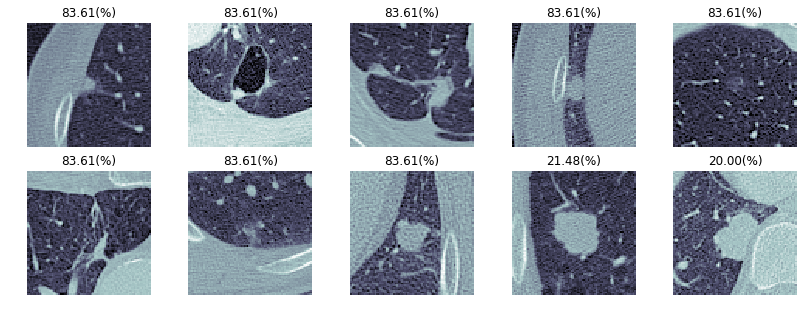

In [59]:
mh = mp[:,0] - mp[:,1]

plt.figure(figsize=(14,5))
for i, m in enumerate(maligns[np.argsort(mh)[-20:-10]]):
    plt.subplot(2,5,i+1)
    plt.imshow(m.reshape((80,80)), plt.cm.bone)
    sub = mh[np.argsort(mh)][-20:-10][i]
    print(sub)
    plt.title('%.2f(%%)' % (malig_prob(sub) * 100))
    plt.axis('off')

plt.show()

In [56]:
mh[:10]

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1.], dtype=float32)

In [64]:
np.mean(np.array([[1,2],[3,4]]), axis=1)

array([ 1.5,  3.5])